In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = './data'

adata = sc.read(os.path.join(data_dir,'single.filtered.updated.h5ad'))

Only considering the two last: ['.updated', '.h5ad'].
Only considering the two last: ['.updated', '.h5ad'].


## UMAP Plots

In [3]:
from scipy.stats import ttest_ind

n_components = 40 #70
perturb_gene_list = sorted(list(set(adata.obs['condition'])))
perturb_gene_list.remove('NTC')

ntc_inds = np.where(adata.obs['condition'] == 'NTC')[0]

p_mat = np.zeros((n_components,len(perturb_gene_list)))
sign_mat = np.zeros(p_mat.shape)

for j,perturb_gene in enumerate(perturb_gene_list):
    print(j)
    filtered_adata = adata[(adata.obs['condition'] == 'NTC') | (adata.obs['condition'] == perturb_gene)]
    for i in range(n_components):
        ntc_vals = adata[adata.obs['condition'] == 'NTC'].obsm['X_nmf'][:,i]
        cond_vals = adata[adata.obs['condition'] == perturb_gene].obsm['X_nmf'][:,i]
        
        t,p = ttest_ind(ntc_vals, cond_vals, axis=0, equal_var=False)
        p_mat[i,j] = p
        sign_mat[i,j] = (cond_vals.mean() > ntc_vals.mean()).astype(int)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [4]:
from statsmodels.stats.multitest import fdrcorrection

q_mat = np.zeros(p_mat.shape)
for j in range(q_mat.shape[1]):
    q_mat[:,j] = fdrcorrection(p_mat[:,j])[1]
        
q_mat = -np.log10(q_mat) * (sign_mat-0.5)*2

In [5]:
factors2keep_perturb = np.where((abs(q_mat) > 2).sum(1))[0]
print(np.array(factors2keep_perturb))

conds2keep_perturb = np.where((abs(q_mat) > 2).sum(0))[0]
print(np.array(conds2keep_perturb))

filtered_q_mat = q_mat[factors2keep_perturb][:,conds2keep_perturb]

[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39]
[ 0  1  2  3  4  5  8  9 10 11 13 14 15 16 18 19 20 21 22 23 25 26]


In [6]:
cell_cycle_factors = [6,9,25]

de_factor_inds = [i for i in factors2keep_perturb if i not in cell_cycle_factors]
print(len(de_factor_inds))
adata.obsm['X_nmf_de'] = adata.obsm['X_nmf'][:,de_factor_inds]

34


### All Factors

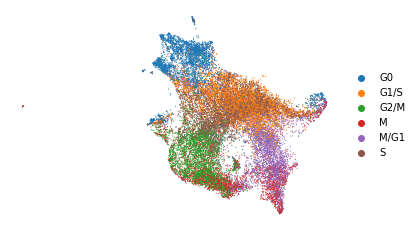

In [8]:
sc.pp.neighbors(adata,use_rep='X_nmf',n_neighbors=15)
sc.tl.umap(adata,min_dist=0.1)
fg = sc.pl.umap(adata,color='cell_cycle_phase',frameon=False,title='',return_fig=True)

### Cell Cycle Only

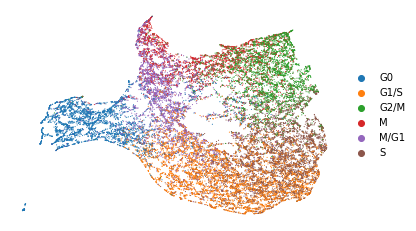

In [11]:
adata.obsm['X_nmf_cc'] = adata.obsm['X_nmf'][:,cell_cycle_factors]
sc.pp.neighbors(adata,use_rep='X_nmf_cc',n_neighbors=15)
sc.tl.umap(adata,min_dist=0.1)
fg = sc.pl.umap(adata,color='cell_cycle_phase',frameon=False,title='',return_fig=True)

### DE Genes Only

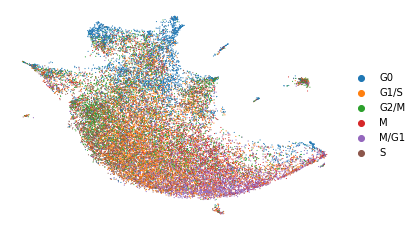

In [13]:
data_dir = './data'

adata = sc.read(os.path.join(data_dir,'single.filtered.updated.h5ad'))
sc.pp.neighbors(adata,use_rep='X_nmf_de',n_neighbors=15)
sc.tl.umap(adata,min_dist=0.1)
fg = sc.pl.umap(adata,color='cell_cycle_phase',frameon=False,title='',return_fig=True)

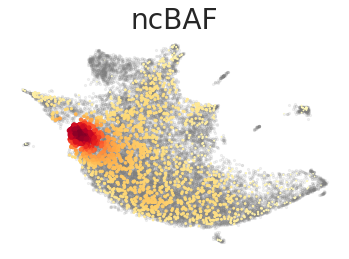

In [3]:
from scipy.stats import gaussian_kde

sns.set_style(style='white')
umap_embeddings = adata.obsm['X_umap']

inds = np.where((adata.obs['condition'] == 'SMARCD1') | (adata.obs['condition'] == 'BRD9'))[0]
other_inds = [i for i in range(adata.shape[0]) if i not in inds]

plt.scatter(umap_embeddings[other_inds,0],umap_embeddings[other_inds,1],c='grey',s=5,alpha=0.1)

xy = np.vstack([umap_embeddings[inds,0],umap_embeddings[inds,1]])
z = gaussian_kde(xy)(xy)
min_z = np.min(z)
max_z = np.max(z)
z = (z - min_z) / (max_z - min_z)

plt.scatter(umap_embeddings[inds,0],umap_embeddings[inds,1],c=z,s=z/z.max()*20,cmap='YlOrRd')
plt.grid(False)
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.title('ncBAF',fontsize=28)
plt.axis('off')
plt.show()

/data/cb/alexwu/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'complex' as categorical
/data/cb/alexwu/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1156: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_over('black')
/data/cb/alexwu/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1157: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered col

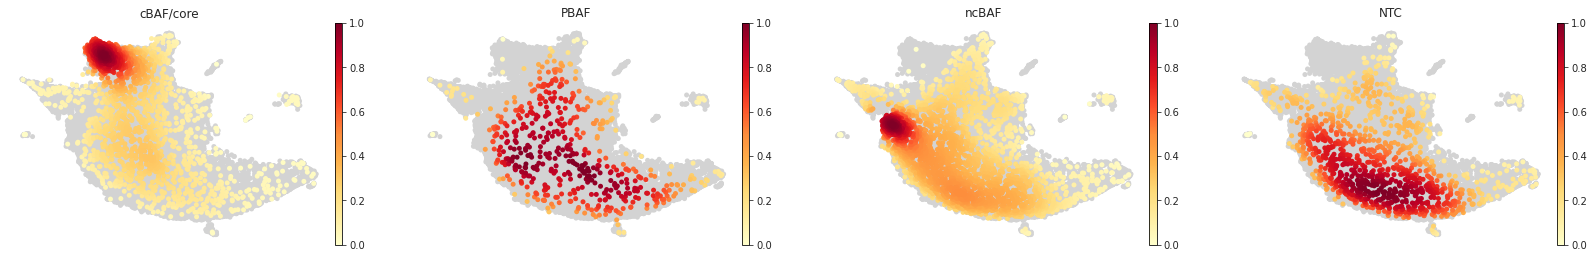

In [4]:
cat1 = ['SMARCA4','ARID1A','SMARCB1','SMARCE1']
cat2 = ['ARID2','BRD7','PBRM1']
cat3 = ['BRD9','GLTSCR1','SMARCD1']
cat4 = ['NTC']

cat_list = []
for n in adata.obs['condition'].values:
    if n in cat1:
        cat_list.append('cBAF/core')
    elif n in cat2:
        cat_list.append('PBAF')
    elif n in cat3:
        cat_list.append('ncBAF')
    elif n in cat4:
        cat_list.append('NTC')
    else:
        cat_list.append('other')

adata.obs['complex'] = cat_list

sc.tl.embedding_density(adata, basis='umap', groupby='complex')

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'

fg = sc.pl.embedding_density(adata, basis='umap', groupby='complex',group=['cBAF/core','PBAF','ncBAF','NTC'],fg_dotsize=100,\
                       bg_dotsize=100,return_fig=True,frameon=False)

### Order Louvain Clusters by Effect

In [86]:
from hotelling.stats import hotelling_t2

ntc_nmf = adata.obsm['X_nmf_de'][adata.obs['condition'] == 'NTC']

louvain_hotelling_dict = {cluster_no: hotelling_t2(ntc_nmf, adata.obsm['X_nmf_de'][adata.obs['louvain'] == cluster_no])[0]
                          for cluster_no in set(adata.obs['louvain'])}

sorted_clusters = [k for k, v in sorted(louvain_hotelling_dict.items(), key=lambda item: item[1])]
rename_cluster_dict = {k: str(i) for i,k in enumerate(sorted_clusters)}

adata.obs['louvain_sorted'] = [rename_cluster_dict[n] for n in adata.obs['louvain']]

### Louvain Enrichment

In [89]:
perturb_gene_list = sorted(list(set(adata.obs['condition'])))

from scipy.stats import fisher_exact


num_clusters = len(set(adata.obs['louvain_sorted']))
odds_enrich_mat = np.zeros((num_clusters,len(perturb_gene_list)))

p_mat_deplete = np.zeros((num_clusters,len(perturb_gene_list)))
for cluster_no in range(num_clusters):
    for j,perturb_gene in enumerate(perturb_gene_list):
        cond1 = ((adata.obs['louvain_sorted'] == str(cluster_no)) & (adata.obs['condition'] == perturb_gene)).sum()
        cond2 = ((adata.obs['louvain_sorted'] != str(cluster_no)) & (adata.obs['condition'] == perturb_gene)).sum()
        cond3 = ((adata.obs['louvain_sorted'] == str(cluster_no)) & (adata.obs['condition'] != perturb_gene)).sum()
        cond4 = ((adata.obs['louvain_sorted'] != str(cluster_no)) & (adata.obs['condition'] != perturb_gene)).sum()
        
        odds_ratio,p = fisher_exact([[cond1,cond2],[cond3,cond4]], alternative='less')
        p_mat_deplete[cluster_no,j] = p

q_mat_deplete = np.zeros(p_mat_deplete.shape)
for j in range(q_mat_deplete.shape[1]):
    q_mat_deplete[:,j] = fdrcorrection(p_mat_deplete[:,j])[1]

from scipy.stats import fisher_exact

p_mat_enrich = np.zeros((num_clusters,len(perturb_gene_list)))
for cluster_no in range(num_clusters):
    for j,perturb_gene in enumerate(perturb_gene_list):
        cond1 = ((adata.obs['louvain_sorted'] == str(cluster_no)) & (adata.obs['condition'] == perturb_gene)).sum()
        cond2 = ((adata.obs['louvain_sorted'] != str(cluster_no)) & (adata.obs['condition'] == perturb_gene)).sum()
        cond3 = ((adata.obs['louvain_sorted'] == str(cluster_no)) & (adata.obs['condition'] != perturb_gene)).sum()
        cond4 = ((adata.obs['louvain_sorted'] != str(cluster_no)) & (adata.obs['condition'] != perturb_gene)).sum()
        
        odds_ratio,p = fisher_exact([[cond1,cond2],[cond3,cond4]], alternative='greater')
        p_mat_enrich[cluster_no,j] = p
        odds_enrich_mat[cluster_no,j] = odds_ratio

q_mat_enrich = np.zeros(p_mat_enrich.shape)
for j in range(q_mat_enrich.shape[1]):
    q_mat_enrich[:,j] = fdrcorrection(p_mat_enrich[:,j])[1]

# q_mat_enrich = p_mat_enrich.copy()

negate_inds = ((-np.log10(q_mat_enrich) > -np.log10(q_mat_deplete)).astype(int)-0.5)*2

q_mat = np.zeros((num_clusters,len(perturb_gene_list)))
q_mat += (np.log10(q_mat_enrich) * (-np.log10(q_mat_enrich) > -np.log10(q_mat_deplete)).astype(int)*-1)
q_mat += (np.log10(q_mat_deplete) * (-np.log10(q_mat_enrich) < -np.log10(q_mat_deplete)).astype(int))


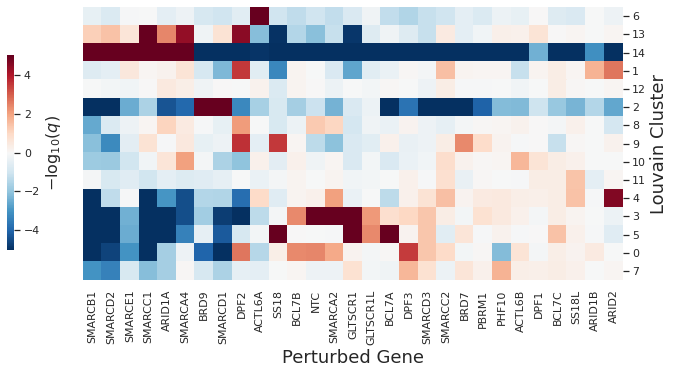

In [90]:
from matplotlib.patches import Rectangle

louvain_cluster_list = sorted(list(set(adata.obs['louvain_sorted'].values.astype(int))))

df = pd.DataFrame(np.clip(q_mat,-5,5).T,index=np.array(perturb_gene_list),columns=louvain_cluster_list)
sns.set() #font_scale=1)
fg = sns.clustermap(df.T,figsize=(10,6),cbar_kws={'label': '$-\log_{10}(q)$'},metric='correlation',cmap='RdBu_r',\
                   vmin=-5,vmax=5)

ax = fg.ax_heatmap
ax.set_ylabel('Louvain Cluster',fontsize=18)
ax.set_xlabel('Perturbed Gene',fontsize=18)
ax.figure.axes[-1].yaxis.label.set_size(16)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0) #, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90) #, fontsize = 8)

fg.ax_col_dendrogram.set_visible(False)
fg.ax_row_dendrogram.set_visible(False)

fg.cax.set_position([0.1, .25, .01, .45])
plt.show()

#### Label UMAP with Enriched Perturbations in Each Cluster

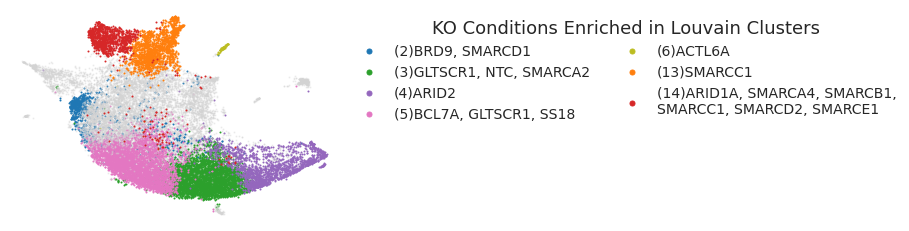

In [92]:
color_sequence = [c for i,c in enumerate(sns.color_palette("tab10")) if i % 2 == 0]
color_sequence.extend([c for i,c in enumerate(sns.color_palette("tab10")) if i % 2 != 0])

i = 0
# plt.figure(figsize=(5,5))
for k in range(len(set(adata.obs['louvain_sorted']))):
    cluster_inds = np.where(adata.obs['louvain_sorted'] == str(k))[0]
    if int(k) not in enriched_perturb.keys():
        plt.scatter(adata.obsm['X_umap'][cluster_inds,0],adata.obsm['X_umap'][cluster_inds,1],\
                    color='lightgrey',s=1,alpha=0.3,marker='o')
        
    else:
        if len(enriched_perturb[k]) > 5:
            label = '({})'.format(k) + ', '.join(enriched_perturb[k][0:3]) + ',\n' + ', '.join(enriched_perturb[k][3:])
        else:
            label = '({})'.format(k) + ', '.join(enriched_perturb[k])
        plt.scatter(adata.obsm['X_umap'][cluster_inds,0],adata.obsm['X_umap'][cluster_inds,1],\
                    label=label,s=1,color=color_sequence[i],marker='o')
        i += 1
        
plt.grid(False)
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.axis('off')
plt.show()